In [78]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

chess_king_rook_vs_king = fetch_ucirepo(id=23) 
# data (as pandas dataframes) 
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets  


In [79]:
df = pd.concat([X, y], axis=1)
df_proc = df.copy()

print(df['white-depth-of-win'].unique())

['draw' 'zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight'
 'nine' 'ten' 'eleven' 'twelve' 'thirteen' 'fourteen' 'fifteen' 'sixteen']


In [ ]:
map_pattern = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
map_win = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
    'fifteen': 15, 'sixteen': 16
}

map_cols = ['white-king-file', 'white-rook-file', 'black-king-file']
for col in map_cols:
    df_proc[col] = df_proc[col].map(map_pattern)

df_proc['white-depth-of-win'] = df_proc['white-depth-of-win'].map(map_win)

dx = abs(df_proc['white-king-file'] - df_proc['black-king-file'])
dy = abs(df_proc['white-king-rank'] - df_proc['black-king-rank'])

df_proc['dist_euclidean'] = np.sqrt(dx**2 + dy**2)
df_proc['dist_manhattan'] = dx + dy
df_proc['dist_chebyshev'] = np.maximum(dx, dy)

#Obliczenia do zadania 3 - jak miałem je w komórce od zadania 3 to raz działało raz nie, tutaj zawsze działało, niestety nie miałem czasu tego rpzeanalizować z uwagi na godzinę 23:49 25.01
dist_x_edge = df_proc['black-king-file'].apply(lambda x: min(x - 1, 8 - x))
dist_y_edge = df_proc['black-king-rank'].apply(lambda y: min(y - 1, 8 - y))
df_proc['bk_edge_dist'] = np.minimum(dist_x_edge, dist_y_edge)

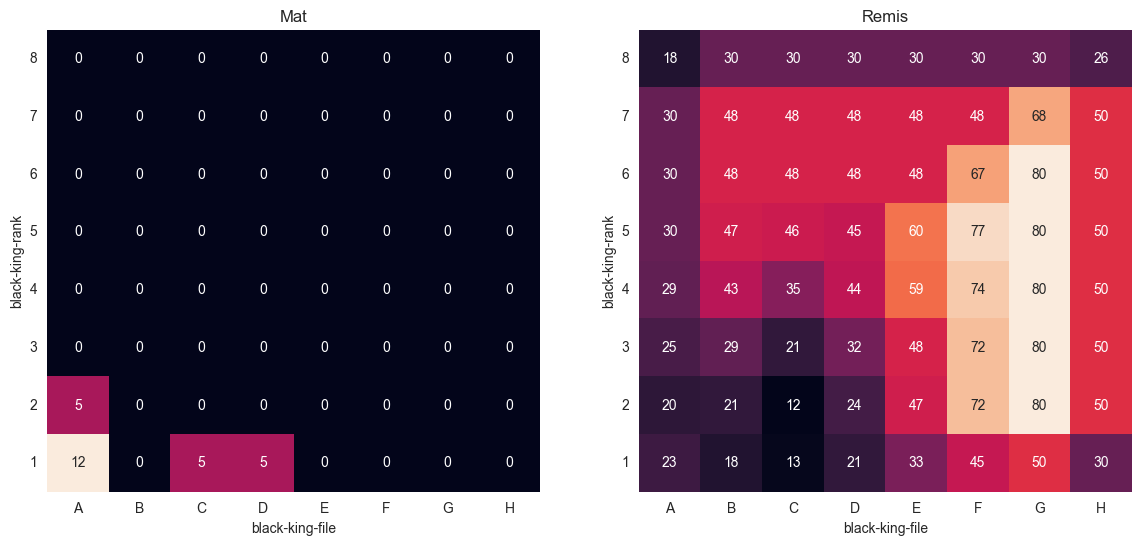

In [81]:
# Zadanie 1
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
scenarios = [(0, 'Mat'), (-1, 'Remis')]

labels_file = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
labels_rank = [1, 2, 3, 4, 5, 6, 7, 8]

for i, (state, title) in enumerate(scenarios):
    found = df_proc[df_proc['white-depth-of-win'] == state]
    
    end_data = pd.crosstab(found['black-king-rank'], found['black-king-file'])
    #zeby 'macierz' miała rozmiary szachownicy, bez tego będzie miała mniejsze wymiary jesli mamy dużo zer (mamy)
    end_data = end_data.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)
    
    sns.heatmap(end_data.sort_index(ascending=False), ax=axes[i], annot=True, cbar=False)
    
    axes[i].set_title(title)
    axes[i].set_xticklabels(labels_file)
    axes[i].set_yticklabels(reversed(labels_rank), rotation=0)

plt.show()


In [ ]:
#W przytpadku mata najczęściej ma on miejsce na A1 i w okolicy tego pola, w przypadku remisu może się on odbyć na całej planszy, jednak najczęściej jest to kolumna G i F

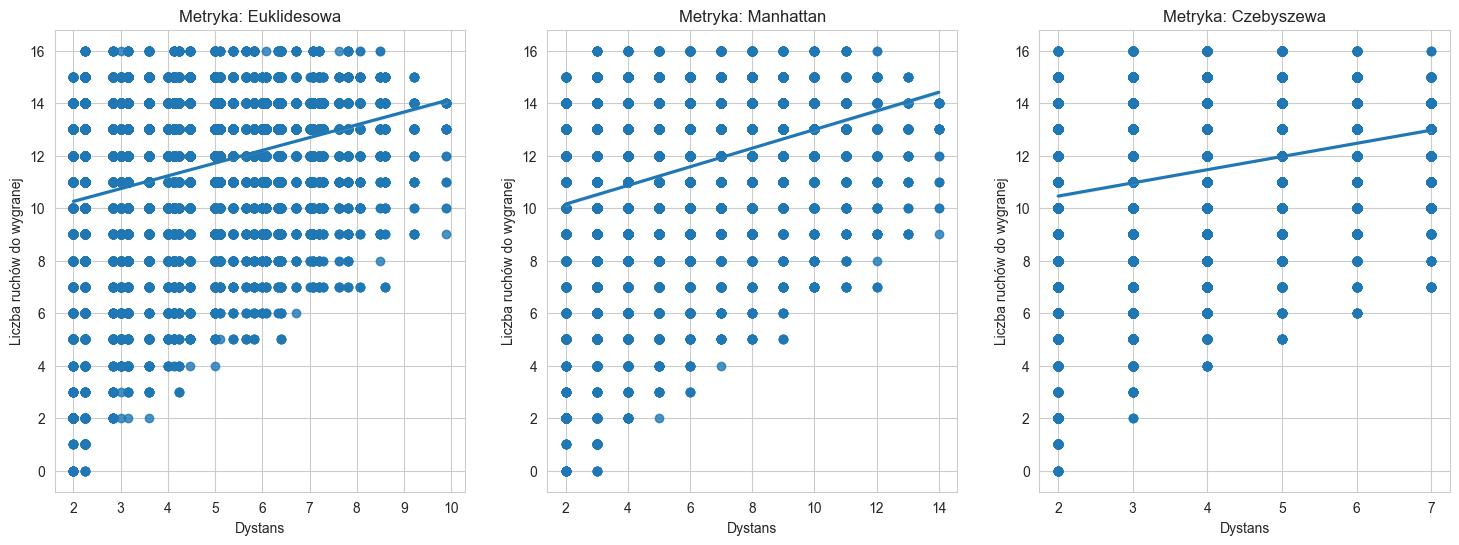

In [82]:
#Zadanie 2
df_won = df_proc[df_proc['white-depth-of-win'] != -1]
fig1, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = [
    ('dist_euclidean', 'Euklidesowa'), 
    ('dist_manhattan', 'Manhattan'), 
    ('dist_chebyshev', 'Czebyszewa')
]

for i, (col_name, label) in enumerate(metrics):
    sns.regplot(data=df_won, x=col_name, y='white-depth-of-win', ax=axes[i])
    
    axes[i].set_title(f'Metryka: {label}')
    axes[i].set_xlabel('Dystans')
    axes[i].set_ylabel('Liczba ruchów do wygranej')

plt.show()

In [ ]:
#Ciężko jednoznacznie stwierdzić, która metryka najlepiej przewiduje ilość ruchów potrzebnych do wygranej, jednak przy większej ilości potrzebnych ruchów (13/14) może być to metryka Manhattan

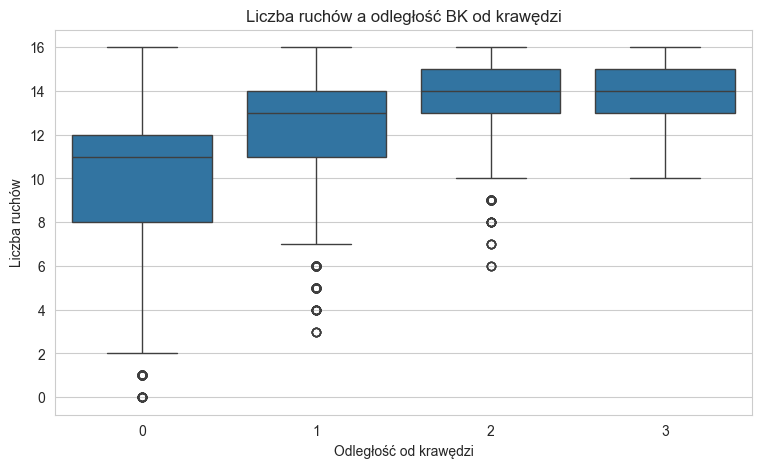

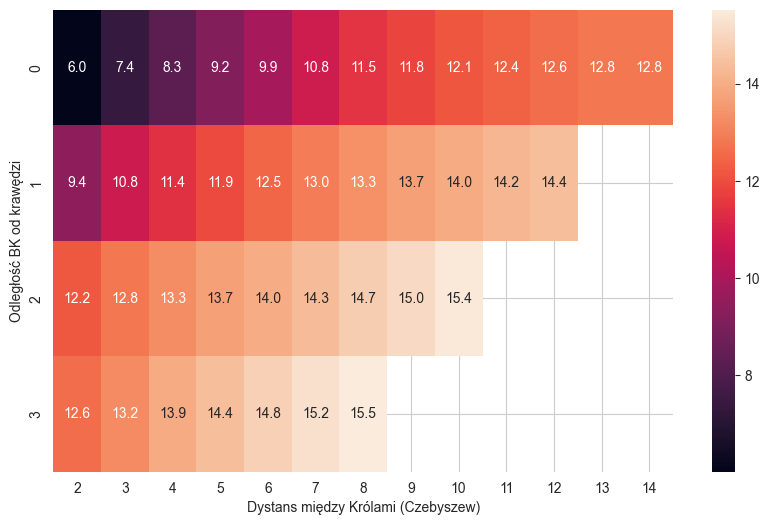

In [88]:
# Zadanie 3
plt.figure(figsize=(9, 5))
sns.boxplot(data=df_won, x='bk_edge_dist', y='white-depth-of-win')
plt.title('Liczba ruchów a odległość BK od krawędzi')
plt.xlabel('Odległość od krawędzi')
plt.ylabel('Liczba ruchów')
plt.show()

heatmap_data = df_won.groupby(['bk_edge_dist', 'dist_manhattan'])['white-depth-of-win'].mean().unstack()
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f")
plt.ylabel('Odległość BK od krawędzi')
plt.xlabel('Dystans między Królami (Czebyszew)')
plt.show()

In [ ]:
#Tak, jest to przydatna informacja - im większa odległość czarnego króla od krawędzi tym, najpewniej, będziemy potrzebowali więcej ruchów do skończenia gry.
#Tak, na heatmapie widać, że mniejsza odległość między królami również pomaga w szybszym zakończeniu gry.